# 04. Training MLP model

#### This notebook trains an MLP to predict Gurobi runtime based on structural features and param_id.
It supports:
- One-hot encoding for `param_id`
- Train/Val/Test split
- TensorBoard visualization

## Imports

In [1]:
import pandas as pd
import torch
import sys
import os
import matplotlib.pyplot as plt
from torch.utils.data import random_split, DataLoader

In [2]:
# set up project root path
project_root = os.path.abspath(os.path.join(os.getcwd(), ".."))
if project_root not in sys.path:
    sys.path.append(project_root)

In [3]:
from src.train_model import MIPDataset, MLPRegressor, load_data, train_loop, evaluate_loop

## Datasets

In [4]:
OUTPUT_CSV = "../data/processed/modeldataset.csv"
FEATURE_COLS = ["VariablesVari.", "BinariesBina.", "IntegersInte.",
                "ContinuousCont.", "ConstraintsCons.", "Nonz.Nonz."]

X_scaled, y = load_data(OUTPUT_CSV, FEATURE_COLS)
dataset = MIPDataset(X_scaled, y)

In [5]:
n = len(dataset)
n_test = int(n * 0.1)
n_val = int(n * 0.1)
n_train = n - n_val - n_test

train_set, val_set, test_set = random_split(dataset, [n_train, n_val, n_test], generator=torch.Generator().manual_seed(42))

train_loader = DataLoader(train_set, batch_size=32, shuffle=True)
val_loader   = DataLoader(val_set, batch_size=64)
test_loader  = DataLoader(test_set, batch_size=64)

## Training

In [6]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model = MLPRegressor(input_dim=X_scaled.shape[1])
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = torch.nn.MSELoss()

model, train_losses, val_losses = train_loop(model, train_loader, val_loader, optimizer, criterion,
                                        epochs=50, device=device)

[Epoch 01] Train Loss: 163.2112 | Val Loss: 112.1906
[Epoch 02] Train Loss: 186.6873 | Val Loss: 111.0298
[Epoch 03] Train Loss: 153.2160 | Val Loss: 109.8434
[Epoch 04] Train Loss: 163.5269 | Val Loss: 108.6434
[Epoch 05] Train Loss: 142.2539 | Val Loss: 107.4396
[Epoch 06] Train Loss: 160.5673 | Val Loss: 106.1829
[Epoch 07] Train Loss: 164.8508 | Val Loss: 104.8720
[Epoch 08] Train Loss: 130.8515 | Val Loss: 103.5379
[Epoch 09] Train Loss: 147.6894 | Val Loss: 102.1544
[Epoch 10] Train Loss: 153.3983 | Val Loss: 100.6651
[Epoch 11] Train Loss: 189.8420 | Val Loss: 99.0900
[Epoch 12] Train Loss: 134.0101 | Val Loss: 97.4187
[Epoch 13] Train Loss: 132.2628 | Val Loss: 95.6294
[Epoch 14] Train Loss: 130.2973 | Val Loss: 93.7404
[Epoch 15] Train Loss: 139.8690 | Val Loss: 91.7463
[Epoch 16] Train Loss: 134.4151 | Val Loss: 89.5966
[Epoch 17] Train Loss: 111.1944 | Val Loss: 87.2856
[Epoch 18] Train Loss: 153.5674 | Val Loss: 84.8082
[Epoch 19] Train Loss: 119.8668 | Val Loss: 82.1781
[E

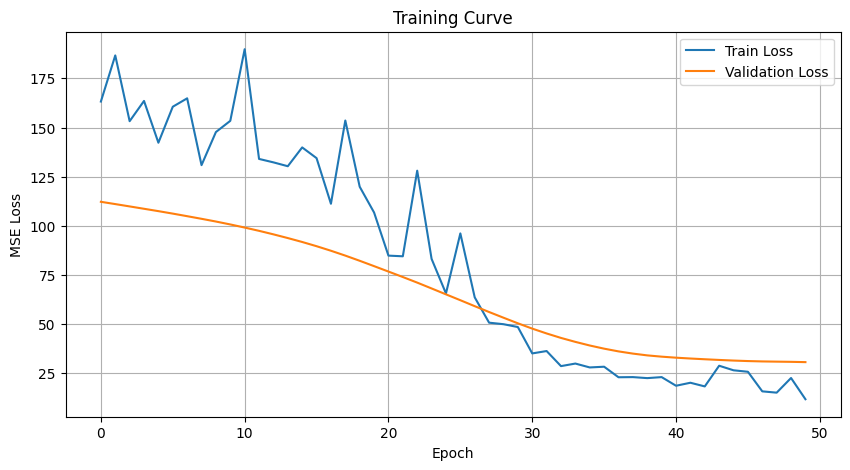

In [7]:
# plot the loss curves
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.title("Training Curve")
plt.legend()
plt.grid(True)
plt.show()

In [8]:
evaluate_loop(model, test_loader, device=device, label="Test")


 Test Set:
  MAE : 3.664458227157593
  R²  : -0.1113986537930911
